<a href="https://colab.research.google.com/github/geopan2000/Loan-Approval-Prediction/blob/main/LoanApprovalPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Clone the GitHub repository
!git clone https://github.com/geopan2000/Loan-Approval-Prediction.git

# Change directory to the cloned repository
%cd Loan-Approval-Prediction

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb

!pip install scikit-optimize
!pip install shap
from skopt import BayesSearchCV
from skopt.space import Real, Integer

from sklearn.model_selection import KFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from google.colab import files

In [ ]:
train_set = pd.read_csv('/content/Loan-Approval-Prediction/data/train.csv')
test_set = pd.read_csv('/content/Loan-Approval-Prediction/data/test.csv')

In [ ]:
print(train_set.isna().sum()) #inspect train set for possible missing values
print(test_set.isna().sum()) #inspect test set for possible missing values

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64
id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


In [ ]:
print(train_set.dtypes) #inspect data types

id                              int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object


In [ ]:
print('The size of the train set is:', train_set.shape)
print('The size of the test set is:', test_set.shape) # the target variable is missing from the set

The size of the train set is: (58645, 13)
The size of the test set is: (39098, 12)


In [ ]:
sample_submission = pd.read_csv('/content/Loan-Approval-Prediction/data/sample_submission.csv')
print(sample_submission.head())

      id  loan_status
0  58645          0.5
1  58646          0.5
2  58647          0.5
3  58648          0.5
4  58649          0.5


In [ ]:
print(train_set.info())
print(train_set['person_home_ownership'].value_counts())
print(train_set['loan_intent'].value_counts())
print(train_set['loan_grade'].value_counts())
print(train_set['cb_person_default_on_file'].value_counts())
print(train_set['loan_status'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [ ]:
train_set['cb_person_default_on_file'].map({'Y': 1, 'N': 0})
train_set['loan_grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})
train_set = pd.get_dummies(train_set, columns=['person_home_ownership', 'loan_intent'])
train_set.drop(['id','loan_grade','cb_person_default_on_file'], axis=1, inplace=True)

test_id=test_set['id']
test_set['cb_person_default_on_file'].map({'Y': 1, 'N': 0})
test_set['loan_grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})
test_set = pd.get_dummies(test_set, columns=['person_home_ownership', 'loan_intent'])
test_set.drop(['id','loan_grade','cb_person_default_on_file'], axis=1, inplace=True)

In [ ]:
print(train_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      58645 non-null  int64  
 1   person_income                   58645 non-null  int64  
 2   person_emp_length               58645 non-null  float64
 3   loan_amnt                       58645 non-null  int64  
 4   loan_int_rate                   58645 non-null  float64
 5   loan_percent_income             58645 non-null  float64
 6   cb_person_cred_hist_length      58645 non-null  int64  
 7   loan_status                     58645 non-null  int64  
 8   person_home_ownership_MORTGAGE  58645 non-null  bool   
 9   person_home_ownership_OTHER     58645 non-null  bool   
 10  person_home_ownership_OWN       58645 non-null  bool   
 11  person_home_ownership_RENT      58645 non-null  bool   
 12  loan_intent_DEBTCONSOLIDATION   

array([[<Axes: title={'center': 'person_age'}>,
        <Axes: title={'center': 'person_income'}>,
        <Axes: title={'center': 'person_emp_length'}>,
        <Axes: title={'center': 'loan_amnt'}>,
        <Axes: title={'center': 'loan_int_rate'}>],
       [<Axes: title={'center': 'loan_percent_income'}>,
        <Axes: title={'center': 'cb_person_cred_hist_length'}>, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

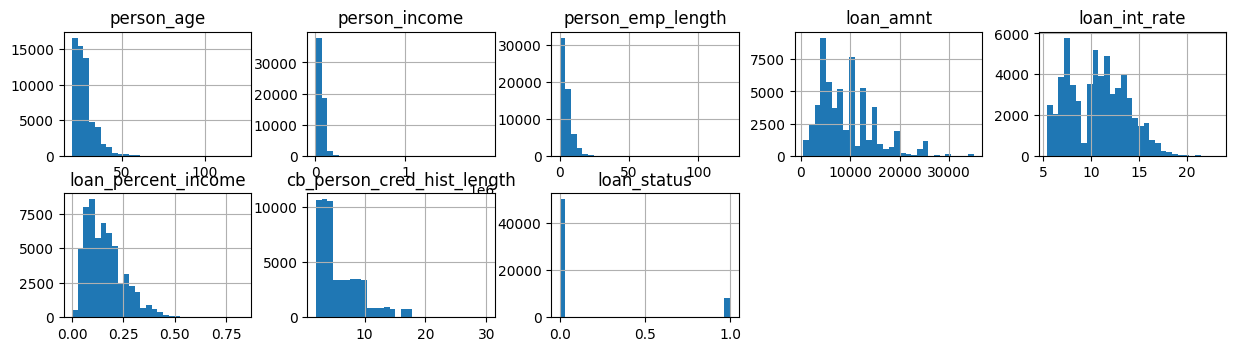

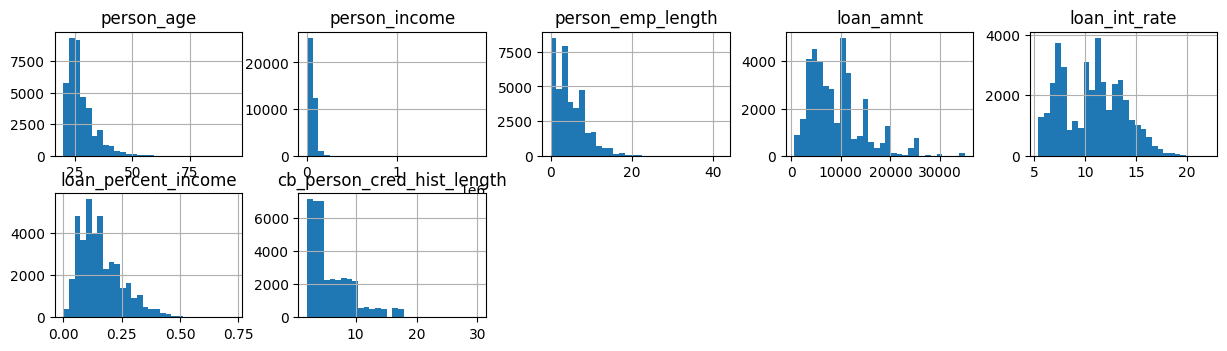

In [ ]:
train_set.hist(bins=30, figsize=(15, 10), layout=(5, 5))
test_set.hist(bins=30, figsize=(15, 10), layout=(5, 5))